In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image

# Read click stream data

In [2]:
df = pd.read_csv('AdClickInfo.csv')
df.head()

,Customer ID,Date Time,Ad ID,Gender,Age,Holiday,Working,probs,click
0,104474,2024-09-01 07:07:24,4,M,40,NaN,False,0.47,1
1,129899,2024-09-01 07:10:42,5,M,20,NaN,False,0.09,1
2,121047,2024-09-01 07:15:12,3,M,50,NaN,False,0.10,0
3,133576,2024-09-01 07:20:03,2,M,47,NaN,False,0.13,0
4,112276,2024-09-01 07:20:52,4,M,45,NaN,False,0.49,0


In [3]:
df[['Ad ID', 'click']].groupby('Ad ID').agg(['count', 'sum']).reset_index()


Ad ID  click      
         count   sum
0     1  20143  3476
1     2  19833  4266
2     3  19951  2079
3     4  19972  3678
4     5  20101  2981

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Customer ID  100000 non-null  int64  
 1   Date Time    100000 non-null  object 
 2   Ad ID        100000 non-null  int64  
 3   Gender       100000 non-null  object 
 4   Age          100000 non-null  int64  
 5   Holiday      3069 non-null    object 
 6   Working      100000 non-null  bool   
 7   probs        100000 non-null  float64
 8   click        100000 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 6.2+ MB


In [5]:
def read_batch(df, row = 0, batch_size = 1000):
    dfp = df[row: row + batch_size]
    dfs = dfp[['Ad ID', 'click']].groupby('Ad ID').agg(['count', 'sum']).reset_index()
    dfs.columns = ['Ad ID', 'click count', 'click sum']
    return (dfs)

def add_batch(df1, df2):
    dfm = pd.concat([df1, df2])
    dfm1 = dfm.groupby('Ad ID').agg('sum').reset_index()
    return (dfm1) 

def compute_ucb(df):
    # assert column names match
    newdf = df.copy()
    newdf['mean'] = 0.
    newdf['ucb'] = 0.
    
    #assert (df.columns == ['Ad ID', 'click count', 'click sum']).all(), 'column names do not match'
    total_shown = df['click count'].sum()
    total_clicked = df['click sum'].sum()
    for i in range(1, 6):
        row = df[df['Ad ID'] == i]
        count = row['click count']
        clicked = row['click sum']
        mean = round(clicked/count, 3)
        # formula for delta and upper confidence bound from 
        #https://analyticsindiamag.com/reinforcement-learning-the-concept-behind-ucb-explained-with-code/
        sd = round (np.sqrt(1.5 * np.log(total_shown)/count), 3)
        #print (i, mean, sd)
        newdf.loc[newdf['Ad ID'] == i, 'mean'] = mean
        newdf.loc[newdf['Ad ID'] == i, 'ucb'] = mean + sd
    return (newdf)

# Compute evolution of mean and UCB over time 

In [6]:
def compute(df, nrounds=100):
    dfm = pd.DataFrame()
    
    evol_dict = {}
    
    for i in range(nrounds):
        start = 1000 * i 
        end = start + 1000
        #print (i, start, end)
    
        # subset dataframe and compute
        dfs_new = read_batch(df, start, end)
        #print (dfs_new)
        
        # add batch 
        if i == 0:
            dfm = dfs_new
        else:
            dfm1 = add_batch(dfs_new, dfm)
            dfm = dfm1.copy()
            #print ('lenght of dfm', len(dfm1))
    
        # compute ucb
        dfucb = compute_ucb(dfm)
        dfucb['round'] = i
        
        if i == 0:
            dff = dfucb
        else:
            dff = pd.concat([dff, dfucb])
        
    return dff

In [7]:
new = compute(df)
new

,Ad ID,click count,click sum,mean,ucb,round
0,1,176,48,0.273,0.516,0
1,2,225,50,0.222,0.437,0
2,3,205,23,0.112,0.337,0
3,4,201,51,0.254,0.481,0
4,5,193,16,0.083,0.315,0
...,...,...,...,...,...,...
0,1,517506,66268,0.128,0.135,99
1,2,504808,106439,0.211,0.218,99
2,3,508037,53444,0.105,0.112,99
3,4,506557,92532,0.183,0.190,99


# Plot to Visualize

In [8]:
def plotucb(df):
    colors = ['w', 'b', 'g', 'r', 'c', 'k'] 
    for i in range(1, 6):
        dff = df[df['Ad ID'] == i]
        plt.plot(dff['round'], dff['mean'], color = colors[i])
        plt.plot(dff['round'], dff['ucb'], '--', c = colors[i])

    plt.legend(['1','1', '2','2', '3', '3', '4', '4', '5', '5'])
    plt.xlabel('round')
    plt.ylabel('CTR estimate. solid line: mean, dotted: UCB')
    plt.title('Ad CTR estimates')
    plt.show()

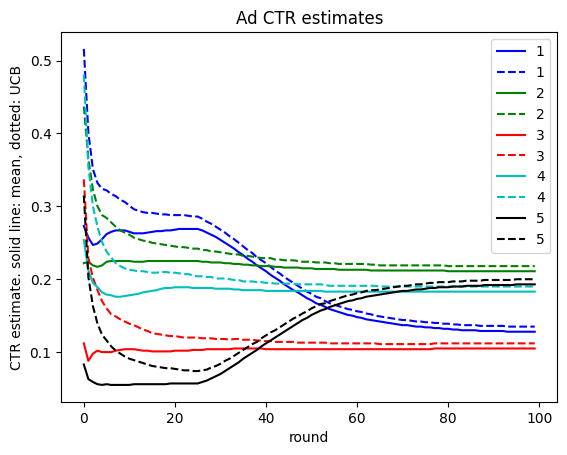

In [9]:
plotucb(new)

# Contextual Multi Armed Bandits


## By Gender

In [10]:
# Learn separately by gender
df_female = df[df['Gender'] == 'F']
df_male = df[df['Gender'] == 'M']

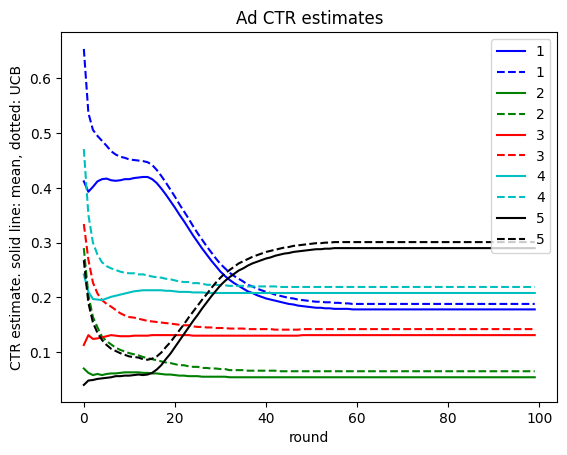

In [11]:
new_male = compute(df_male)
plotucb(new_male)

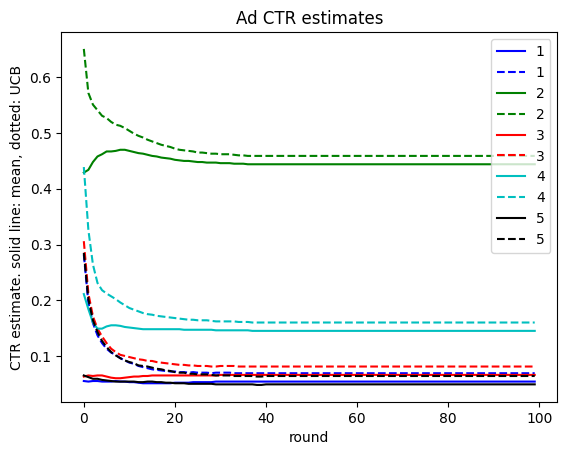

In [12]:
new_female = compute(df_female)
plotucb(new_female)

In [13]:
len(df_male)

59711

## By Gender and Age Group

In [14]:
# Learn separately by gender
df_male_young = df[(df['Gender'] == 'M') & (df['Age'] <= 40)]

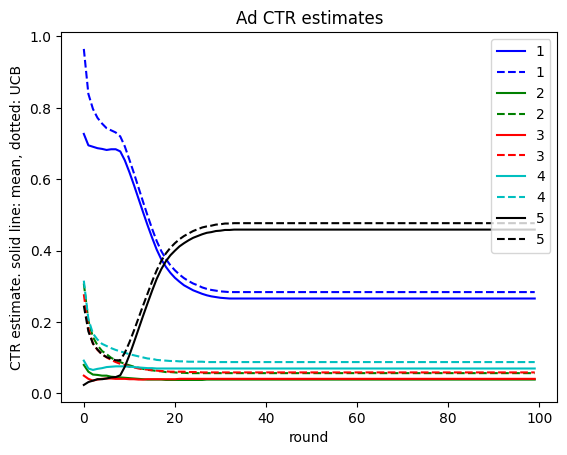

In [15]:
new_male_young = compute(df_male_young)
plotucb(new_male_young)

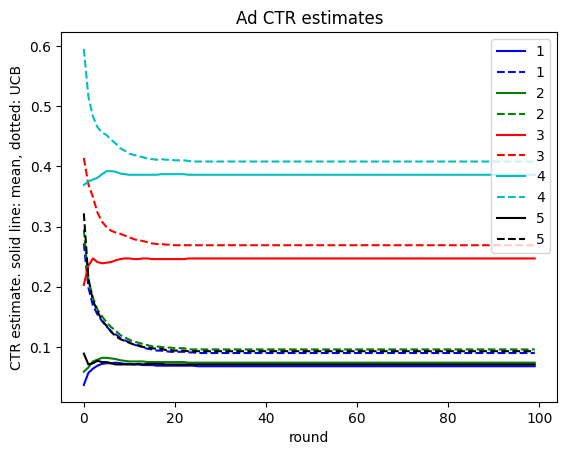

In [16]:
df_male_old = df[(df['Gender'] == 'M') & (df['Age'] > 40)]
new_male_old = compute(df_male_old)
plotucb(new_male_old)